# Simulating FEE on MC data

In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import system_of_units as units
import tables
import mplFunctions as mpl
import wfmFunctions as wfm

In [3]:
import FEE as FE

In [4]:
import time

## Revised on:

In [5]:
print(time.strftime("%d/%m/%Y"))

31/10/2016


In [6]:
print(time.strftime("%H:%M:%S"))

18:53:21


###  Code exercized

In [7]:
!pep8 ../Sierpe/FEE.py

In [8]:
!pyflakes ../Sierpe/FEE.py

## SIMULATING THE EFFECT OF ELECTRONICS OVER MC DATA

### PROCEDURE

1. Read MCRD (bins of 1 ns).
2. Convolute with SPE response to form a signal_i (units of A)
3. Decimate the signal.
4. Simulate the effect of the filter.

#### List the files

In [9]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5
electrons.2500.0keV.z250mm.next_10000.root.h5
electrons.40.0keV.z250mm.next_10000.root.h5


#### Open and inspect file

In [10]:
e40 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_10000.root.h5','r+')

In [11]:
e40

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_10000.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(1000, 12, 800000), zlib(4)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(1000, 1789, 800), zlib(4)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 800)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCTracks (Table(4898,), zlib(4)) ''
  

#### loading the PMTRD vector: train of SPE in bins of 1 ns

In [12]:
pmtrd = e40.root.pmtrd

#### Plot pmtrd for the first event, first PMT

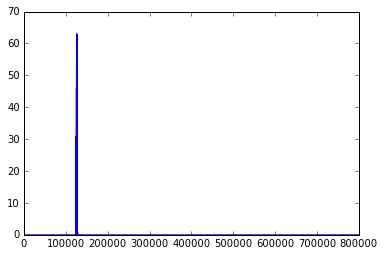

In [13]:
plt.plot(pmtrd[0,0])

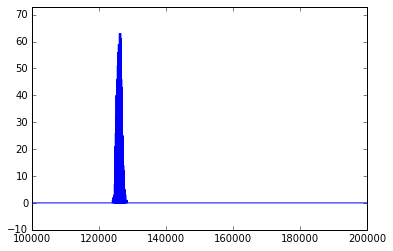

In [14]:
mpl.plts(pmtrd[0,0], signal_start=100000, signal_end=200000, offset=10)

#### signal_i : convolute pmtrd with spe

In [15]:
spe = FE.SPE(pmt_gain=4.5e6)

In [16]:
signal_i = FE.spe_pulse_from_vector(spe,pmtrd[0,0])

#### Create FEE instance

In [18]:
fee = FE.FEE(gain=FE.MEASURED_GAIN, C2=8*units.nF, C1=2714*units.nF,
                  R1=1567*units.ohm, Zin=62*units.ohm, 
                  f_sample=1./(25*units.ns), f_LPF1=3*units.MHZ, 
                  f_LPF2=10*units.MHZ,
                  noise_FEEPMB_rms=1*FE.NOISE_I,
                  DAQnoise_rms=FE.NOISE_DAQ)

In [19]:
fee


        (C1 =  2714.0 nf,
         C2 =     8.0 nf,
         R1 =  1567.0 ohm,
         Zin =    62.0 ohm,
         gain =   582.2 ohm,
         f_sample =    40.0 MHZ,
         freq_LHPF =   12.25 kHz,
         freq_LPF1 =    3.00 MHZ,
         freq_LPF2 =   10.00 MHZ,
         freq_LHPFd =  0.00061,
         freq_LPF1d =    0.15,
         freq_LPF2d =    0.50,
         noise_FEEPMB_rms =    0.54 muA,
         NIBTS = 12,
         LSB =    0.39 mV,
         volts to adc = 0.00039,
         DAQnoise_rms =    0.31
        )
        

#### plot input function

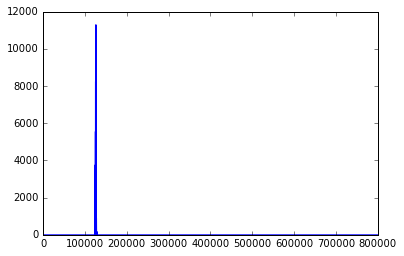

In [20]:
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(fee))   #plot input signal in adc counts

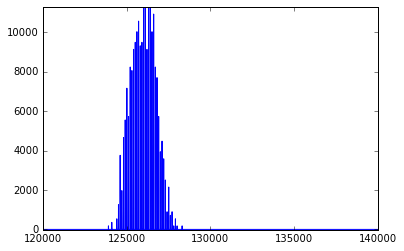

In [23]:
mpl.plts(signal_i*FE.i_to_adc(fee), signal_start=120000, signal_end=140000, offset=20)

### Decimate

#### sampling frequencies

In [54]:
f_sample1 = (1./(1*units.ns))

In [55]:
f_sample2 = (1./(25*units.ns))

In [56]:
f_sample1/units.MHZ

1000.0

In [57]:
f_sample2/units.MHZ

40.0

In [58]:
scale = int(f_sample1/f_sample2)

In [59]:
scale

25

#### simple decimation

In [74]:
signal_daq_1 = signal_i[range(0, len(signal_i), scale)]*FE.i_to_adc(fee)

In [81]:
len(signal_daq_1)

32000

#### "smart" decimation

In [75]:
signal_daq_2 = signal.decimate(signal_i, scale, ftype='fir')*FE.i_to_adc(fee)

In [82]:
len(signal_daq_2)

32000

#### comparison

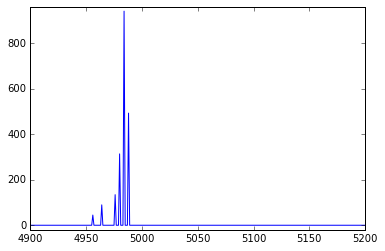

In [84]:
mpl.plts(signal_daq_1, signal_start=4900, signal_end=5200, offset=20)

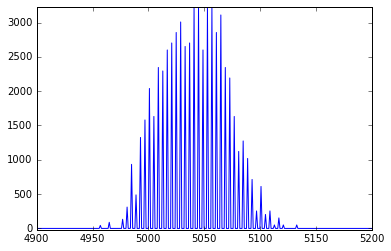

In [85]:
mpl.plts(signal_daq_2, signal_start=4900, signal_end=5200, offset=20)

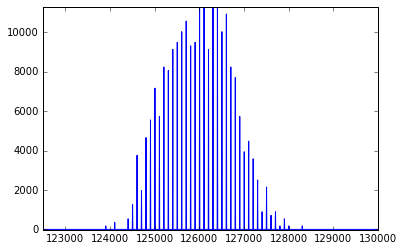

In [88]:
mpl.plts(signal_i*FE.i_to_adc(fee), signal_start=4900*25, signal_end=5200*25, offset=20)

#### "smart decimation" seems to respect better the shape of the signal

#### smart decimation with antialising

In [99]:
aliasingLPF = f_sample2*np.pi
print('aliasing LPF = {} MHZ'.format(aliasingLPF/units.MHZ))

# ANTIALISING Filter at f_sample/2
aliasingLPFd = aliasingLPF/(f_sample1*np.pi)
print('aliasing LPFd = {} MHZ'.format(aliasingLPFd/units.MHZ))
b, a = signal.butter(10, aliasingLPFd, 'low', analog=False)
print('antialising filter: a = {}, b = {}'.format(a,b))

aliasing LPF = 125.663706144 MHZ
aliasing LPFd = 40.0 MHZ
antialising filter: a = [   1.           -9.19673617   38.09105884  -93.56278086  150.93116637
 -167.07697325  128.52956806  -67.8479757    23.52000946   -4.83487511
    0.44753837], b = [  6.50031165e-13   6.50031165e-12   2.92514024e-11   7.80037399e-11
   1.36506545e-10   1.63807854e-10   1.36506545e-10   7.80037399e-11
   2.92514024e-11   6.50031165e-12   6.50031165e-13]


In [100]:
signal_filtered = signal.lfilter(b, a, signal_i)

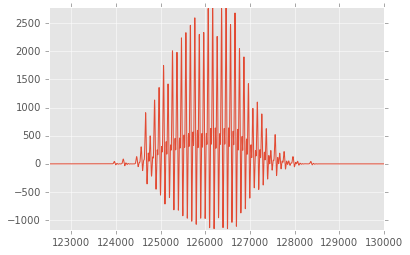

In [101]:
mpl.plts(signal_filtered*FE.i_to_adc(fee), signal_start=4900*25, signal_end=5200*25, offset=20)

#### Does it make sense? Not sure!

In [49]:
signal_daq = FE.daq_decimator(1000.*units.MHZ, 40*units.MHZ, signal_i)

In [50]:
len(signal_daq)

32000

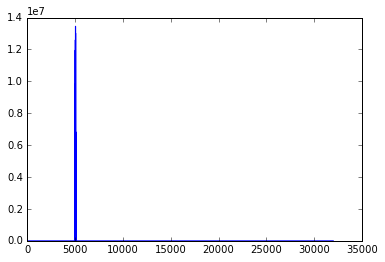

In [52]:
plt.plot(signal_daq)

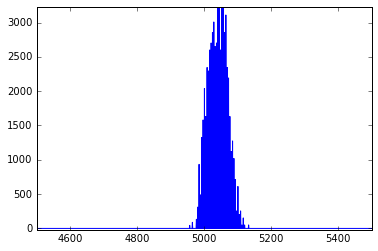

In [53]:
mpl.plts(signal_daq*FE.i_to_adc(fee), signal_start=4500, signal_end=5500, offset=20)

### Convolve with FEE

In [25]:
pmtrwf = FE.signal_v_fee(fee, signal_i)*FE.v_to_adc(fee)  #in adc counts

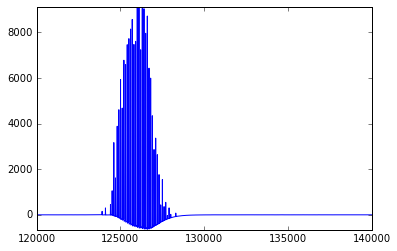

In [26]:
mpl.plts(pmtrwf, signal_start=120000, signal_end=140000, offset=20)